<a href="https://colab.research.google.com/github/krumeto/time_series_utils/blob/main/Time_series_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Agenda for today

- Agree on topics to include and structure of the talk. Possible topics (probably too much for one session, pick and choose). Think of splitting the sessions in an intro + key points and in-depth one
    - Standard TS terms - seasonality, trend, stationarity, additive/multiplicative ...
    - Data EDA and Preprocessing - lag plots, autocorrelation & autocorrelation plots, Granger "causality", seasonal decomposition plots...
    - Intuition behind traditional statistical TS methods - Exponential Smoothing + derivatives (Holt+Winters), ARIMA + derivatives, 
    - Python libraries overview, plus/minuses -
    - Trends in Time series forecasting - M4/M5 competitions winning solutions, ...
- Agree on environment - Possible 
- Find an interesting multivariate timeseries.
- Nominate libraries/algorithms to present. Some options – AutoArima (pmdarima), Prophet, sktime, tsfresh, GluonTS, darts, the whole statsmodels conundrum, etc…


## Resources:
1. Papers + Articles:
- Overview of the M4 competition results: https://www.sciencedirect.com/science/article/pii/S0169207019301128
- M4 Winning method article: https://eng.uber.com/m4-forecasting-competition/
- Long overview paper by Hyndman and Makridakis - https://www.sciencedirect.com/science/article/pii/S0169207019301876
- UBER best practices: https://eng.uber.com/forecasting-introduction/

2. Video:
- Long, practical playlist on time series https://www.youtube.com/watch?v=-r7wB9DJtiU&list=PL3N9eeOlCrP5cK0QRQxeJd6GrQvhAtpBK&ab_channel=AIEngineering
- M5 overview: https://youtu.be/QK16mGnLCig

3. Repos + Code:
- M competitions Repo https://github.com/Mcompetitions
- Repo to the long playlist on time series https://github.com/srivatsan88/End-to-End-Time-Series
- M5 competition collection of documents and code - https://drive.google.com/drive/folders/1D6EWdVSaOtrP1LEFh1REjI3vej6iUS_4
- M5 Kaggle - https://www.kaggle.com/c/m5-forecasting-accuracy
- Nice Prophet notebook https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb
- SKtime Example notebook - https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb
- A very nice Prophet notebook - https://juanitorduz.github.io/fb_prophet/

4. Docs for libraries:

5. Time Series Datasets:
- UCI ML repository https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=&numAtt=&numIns=&type=ts&sort=nameUp&view=table
- St Louis Fed https://fred.stlouisfed.org/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

## File Loading and Merge

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43829 entries, 0 to 43828
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      43829 non-null  datetime64[ns]
 1   actuals   43762 non-null  float64       
 2   avg_temp  43829 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB
None
                 time  actuals  avg_temp
0 2015-01-01 00:00:00   5024.0      -9.7
1 2015-01-01 01:00:00   4773.0      -9.7
2 2015-01-01 02:00:00   4585.0      -9.7
3 2015-01-01 03:00:00   4440.0      -9.7
4 2015-01-01 04:00:00   4418.0      -9.7
                actuals  avg_temp
time                             
2015-01-01  4994.333333      -9.7
2015-01-02  4642.083333      -6.2
2015-01-03  4203.875000       0.2
2015-01-04  4436.208333       0.2
2015-01-05  3497.166667      -1.7
...                 ...       ...
2019-12-27  4588.916667       2.1
2019-12-28  4681.708333       0.3
2019-12-29  

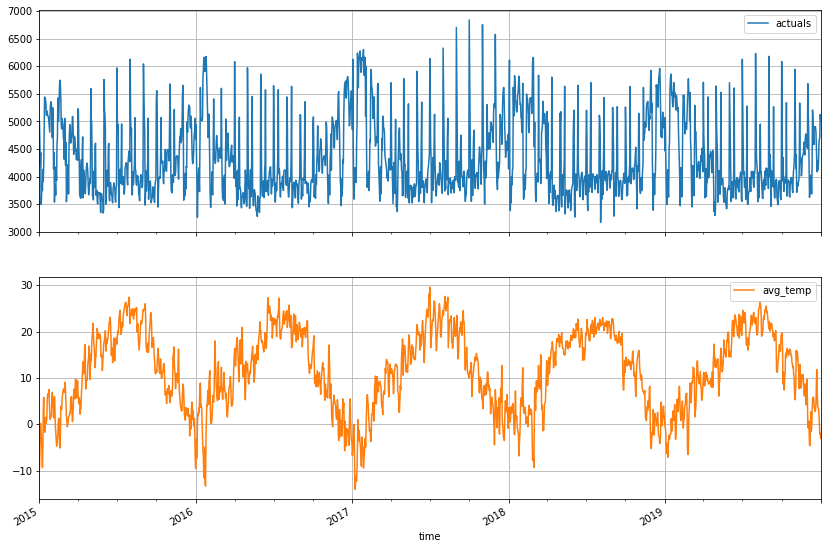

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

def load_energy_data(data_path = '*'):
  """
  Takes the path to the Total Load files as an input.
  Returns a concatinated df, containing the start of each interval, actuals and a forecast
  
  """
  #Load and concat the files
  total_load = pd.DataFrame()
  for file in glob.glob(data_path):
    if 'Total Load' in file:
      partial_df = pd.read_csv(file)
      total_load = pd.concat([total_load, partial_df])

  #Rename the columns
  total_load.columns = ['time_interval', 'forecast', 'actuals']

  #Keep the start of the interval only and change type to datetime
  total_load['time'] = total_load.time_interval.str.split("-", expand=True)[0]

  total_load.time = pd.to_datetime(total_load.time)
  #Change type of actuals to numeric, replacing non-numbers with np.NaN
  total_load.actuals = pd.to_numeric(total_load.actuals, errors='coerce')

  total_load = total_load.drop('time_interval', axis=1)
  total_load['date_object'] = total_load.time.dt.date

  #Keep until incl. 2020
  total_load = total_load.loc[lambda df: df['time'] < "2021-01-01"]

  return total_load[['time', 'actuals', 'forecast', 'date_object']]

def load_temparature(file_path):
  """Read the temperature data and return Sofia averages"""
  temps = pd.read_csv(file_path, usecols=['day', 'София'], parse_dates=['day'])
  temps.columns = ['day', 'avg_temp']
  temps['date_object'] = temps.day.dt.date

  return temps

def merge_datasets(energy_df, temp_df):
  full_df = energy_df.merge(temp_df, on='date_object', how='left')
  
  return full_df.loc[:, ['time', 'actuals', 'avg_temp']]

def resample_as_needed(df, freq = 'D'):
  return df.set_index('time').resample(freq).mean()

if __name__ == "__main__":
  RESAMPLE = True
  energy = load_energy_data()
  temp = load_temparature('avg_temp.csv')
  final_df = merge_datasets(energy, temp)
  print(final_df.info())
  print(final_df.head())

  if RESAMPLE:
    print(final_df.pipe(resample_as_needed))

  final_df.pipe(resample_as_needed).plot(subplots=True, figsize=(14,10), grid=True)
  plt.show()